In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import rioxarray as rio
import numpy as np
import geopandas as gpd
import pandas as pd
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import LinearRegression
from glob import glob
import matplotlib.pyplot as plt
import scipy 
# import utils file
import os
import sys
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent) + "/code/")
from utils import *

# Load data 

In [13]:
# load country data from Natural Earth
country_data = gpd.read_file('../data/country_data/10m_cultural/ne_10m_admin_0_countries.shp')

# drop Baikonur because it creates a duplicate in the ISO_A3_EH column
country_data = country_data[country_data['NAME'] != 'Baikonur']

# calculate the area of each country
country_data['area'] = country_data.to_crs(epsg=6933).area # convert to Equal Earth


# Test global land surface area

## test for globe

In [129]:
# load surface area map
surf_area = rio.open_rasterio('../results/00_preprocessing/land_surface_area.nc')[0,:,:]

# test that the total surface area of our product is within 3% of the total surface area of the land
assert abs(country_data['area'].sum() - surf_area.sum())/country_data['area'].sum() < 0.03, "FAILED"

## test for continents

In [4]:
continent_data = country_data[['geometry','CONTINENT']].dissolve('CONTINENT')
continent_data['area'] = continent_data.to_crs(epsg=6933).area # convert to Equal Earth

In [5]:
# calculate the surface area of each country
surf_area_continents = raster_vector_zonal_stats(continent_data.reset_index(), surf_area,'sum')

# merge data with data from Natural Earth
surf_area_comparison = pd.concat([continent_data.reset_index()['area'],surf_area_continents],keys=['Natural Earth','ours'],axis=1).dropna()

# # calculate deviations and assert they are smaller than 10%
continent_area_ratio = surf_area_comparison['Natural Earth']/surf_area_comparison['ours']

# assert that for all continents except Oceans the difference between our calculated surface area and Natural Earth's is less than 10%
assert continent_area_ratio.drop(index=6).max() < 1.1, 'FAILED'

# Test forest area


In [2]:
# load forest area from FRA
FRA_data = pd.read_excel('../data/supplementary_analysis/forest_area/fra_2020.xlsx',sheet_name='1a_Forest',skiprows=4,index_col=0,usecols='A,M:Q')
FRA_data = FRA_data[FRA_data.index.notna()]

# # change year 1990 to 1992 to compare with ESA CCI data
FRA_data.columns = FRA_data.columns.astype(float).astype(int)
FRA_data = FRA_data.rename(columns = {1990:1992})

# convert from units of 1000 ha to m^2
FRA_data = FRA_data*1e7


In [14]:
# load forest area from ESA CCI for the same years as in FRA
comp_years = [1992,2000,2010,2015,2020]
files = glob('../results/00_preprocessing/ESA_CCI_landcover_processed_*.nc')
ESA_CCI_forest_data  = xr.open_mfdataset([f for f in files if int(f.split('_')[-1].split('.')[0]) in comp_years])['ESA_CCI_landcover_processed'].sel(landcover='forest')
ESA_CCI_forest_data.rio.write_crs(4326,inplace=True);

In [15]:
# calculate forest area for each country
ESA_CCI_forest_country = raster_vector_zonal_stats(country_data.reset_index(),ESA_CCI_forest_data,'sum').unstack()

# set the columns to be the year value
ESA_CCI_forest_country.columns = ESA_CCI_forest_country.columns.year

# set the index to be the ISO3 code
ESA_CCI_forest_country['ISO3'] = country_data['ISO_A3_EH']
ESA_CCI_forest_country.set_index('ISO3',inplace=True)

# remove countries with not ISO3 code
ESA_CCI_forest_country.drop(index='-99',inplace=True)

In [16]:
# assert that the correlation between the our estimates and the FRA data is above 0.9 for all years
for year in FRA_data.columns:
    
    # create a paired table for FRA and our estimates for the year
    pairs = pd.concat([ESA_CCI_forest_country[year],FRA_data[year]],axis=1,keys=['CCI','FRA']).dropna()
    
    # calculate the R2 score
    R2 = r2_score(pairs['CCI'],pairs['FRA'])
    
    # print the R2 score
    print(f'R2 for year {year}: {R2:.3f}')

    # assert that the R2 score is above 0.9
    assert R2>0.9, f'FAILED for year {year}'

R2 for year 1992: 0.959
R2 for year 2000: 0.961
R2 for year 2010: 0.962
R2 for year 2015: 0.963
R2 for year 2020: 0.965


1992 0.9587360108910317 0.9174078731560205
2000 0.9611804248303852 0.9188332611142758
2010 0.9623314875943544 0.917967720147322
2015 0.962604845802738 0.9177394785242204
2020 0.9645717285719487 0.9193825421019509


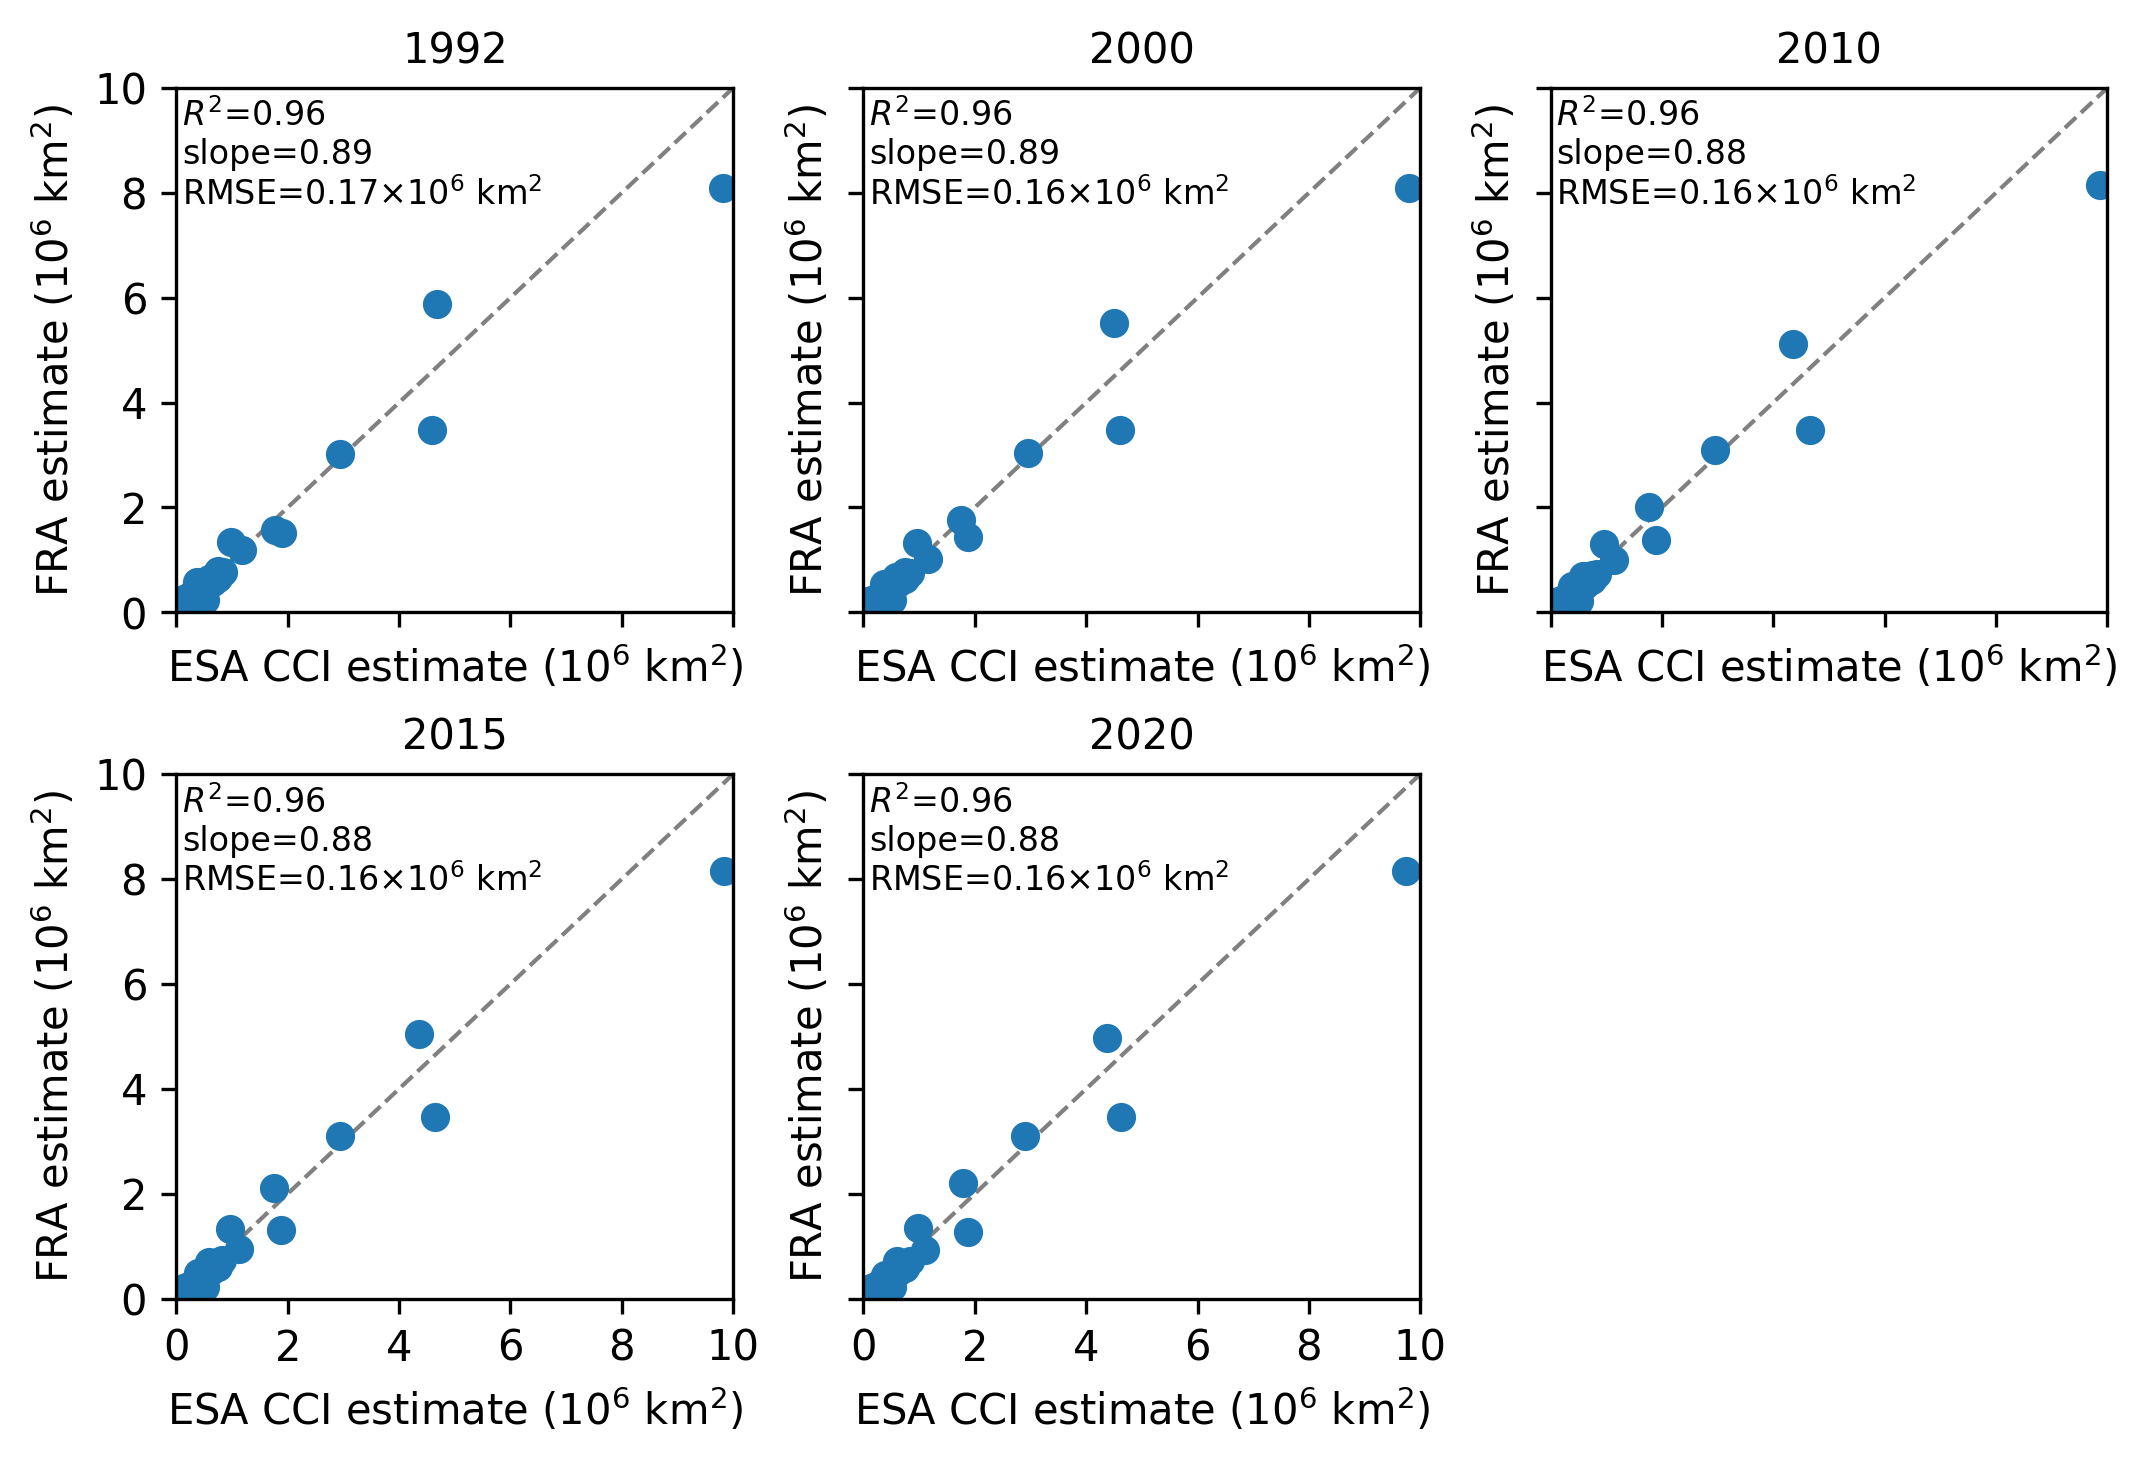

In [17]:
fig,axs = plt.subplots(2,np.ceil(ESA_CCI_forest_country.shape[1]/2).astype(int),dpi=300,constrained_layout=True,sharex=True,sharey=True,figsize=[17.8/2.54,12.1/2.54])
for i,ax in zip(ESA_CCI_forest_country.columns,axs.flatten()):
    slope = 1
    pairs = pd.concat([ESA_CCI_forest_country[i]/1e12,FRA_data[i]/1e12],axis=1,keys=['CCI','FRA']).dropna()
    R2 = r2_score(pairs['CCI']*slope,pairs['FRA'])
    reg = LinearRegression(positive=True,fit_intercept=False).fit(pairs['CCI'].values.T[:,np.newaxis], pairs['FRA'].values.T)
    RMSE = np.sqrt(mean_squared_error(pairs['CCI']*slope,pairs['FRA']))
    print(i,R2,scipy.stats.spearmanr(pairs['CCI']*slope,pairs['FRA']).correlation**2)
    ax.scatter(pairs['CCI']*slope,pairs['FRA'])
    ax.set(xlabel='ESA CCI estimate ($10^6$ km$^2$)',ylabel='FRA estimate ($10^6$ km$^2$)',xlim=[0,10],ylim=[0,10],yticks=[0,2,4,6,8,10],xticks=[0,2,4,6,8,10])
    ax.set_title(f'{i}',fontsize=10)
    ax.text(0.1,9.8,f'$R^2$={round(R2,2)}\nslope={reg.coef_.round(2)[0]}\nRMSE={round(RMSE,2)}$\\times 10^6$ km$^2$',fontsize=8,va='top',ha='left')
    ax.plot([0,10],[0,10],c='grey',lw=1,ls='--',zorder=0)
fig.delaxes(axs[1][2])
